# 🔧 RIAWELC - Kaynak Hatası Sınıflandırma Projesi

**Veri Seti:** Radyografik kaynak görüntüleri  
**Sınıflar:** 
- Difetto1 = CR (Crack - Çatlak)
- Difetto2 = LP (Lack of Penetration - Nüfuziyet Eksikliği)
- Difetto4 = PO (Porosity - Gözeneklilik)  
- NoDifetto = ND (No Defect - Hatasız)

**Toplam Görüntü:** 24,407 adet (224x224 piksel)

---

## 📚 Kaynak
GitHub: https://github.com/stefyste/RIAWELC  
Citation: Benito Totino, Fanny Spagnolo, Stefania Perri (2022)

##  Kütüphaneleri Yükleme

In [2]:
# Temel kütüphaneler
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Tüm kütüphaneler yüklendi!")

✅ Tüm kütüphaneler yüklendi!


##  Veri Yolunu Ayarlama

In [3]:
# Veri seti yolu (Masaüstü)
from pathlib import Path
import os

# Masaüstü yolunu otomatik bul
desktop = Path.home() / 'Desktop'  # Windows/Mac/Linux uyumlu
data_path = desktop / 'RIAWELC' / 'DB - Copy'

# Kontrol et
if not data_path.exists():
    print(f'❌ Veri seti bulunamadı: {data_path}')
    print('\n📌 Lütfen kontrol edin:')
    print('   1. RIAWELC klasörü masaüstünde mi?')
    print('   2. RAR dosyaları açıldı mı?')
    print('   3. DB - Copy klasörü var mı?')
else:
    print(f'✅ Veri seti bulundu: {data_path}')
    print(f'\n📂 İçerik:')
    for item in sorted(data_path.iterdir()):
        if item.is_dir():
            print(f'   └─ {item.name}/')


✅ Veri seti bulundu: C:\Users\Hasan\Desktop\RIAWELC\DB - Copy

📂 İçerik:
   └─ testing/
   └─ training/
   └─ validation/


##  Sınıf Dağılımını İnceleme

In [4]:
# Train, validation, test klasörleri
splits = ['training', 'validation', 'testing']
classes = ['Difetto1', 'Difetto2', 'Difetto4', 'NoDifetto']

# Sınıf isimlerinin açıklamaları
class_names = {
    'Difetto1': 'Çatlak (Crack)',
    'Difetto2': 'Nüfuziyet Eksikliği (Lack of Penetration)',
    'Difetto4': 'Gözeneklilik (Porosity)',
    'NoDifetto': 'Hatasız (No Defect)'
}

# Her split için görüntü sayılarını say
data_info = {}

for split in splits:
    data_info[split] = {}
    for cls in classes:
        class_path = data_path / split / cls
        if class_path.exists():
            num_images = len(list(class_path.glob('*.png')))
            data_info[split][cls] = num_images
        else:
            data_info[split][cls] = 0

# DataFrame oluştur
df = pd.DataFrame(data_info).T
df['TOPLAM'] = df.sum(axis=1)

print("\n📊 Veri Seti Dağılımı:")
print("="*80)
print(df)
print("\n" + "="*80)
print(f"🎯 Toplam Görüntü Sayısı: {df['TOPLAM'].sum():,}")
print("\n📝 Sınıf Açıklamaları:")
for code, name in class_names.items():
    print(f"   • {code:15s}: {name}")


📊 Veri Seti Dağılımı:
            Difetto1  Difetto2  Difetto4  NoDifetto  TOPLAM
training        4962      4108      2893       3900   15863
validation      1908      1580      1113       1500    6101
testing          765       632       446        600    2443

🎯 Toplam Görüntü Sayısı: 24,407

📝 Sınıf Açıklamaları:
   • Difetto1       : Çatlak (Crack)
   • Difetto2       : Nüfuziyet Eksikliği (Lack of Penetration)
   • Difetto4       : Gözeneklilik (Porosity)
   • NoDifetto      : Hatasız (No Defect)


##  Sınıf Dağılımını Görselleştirme

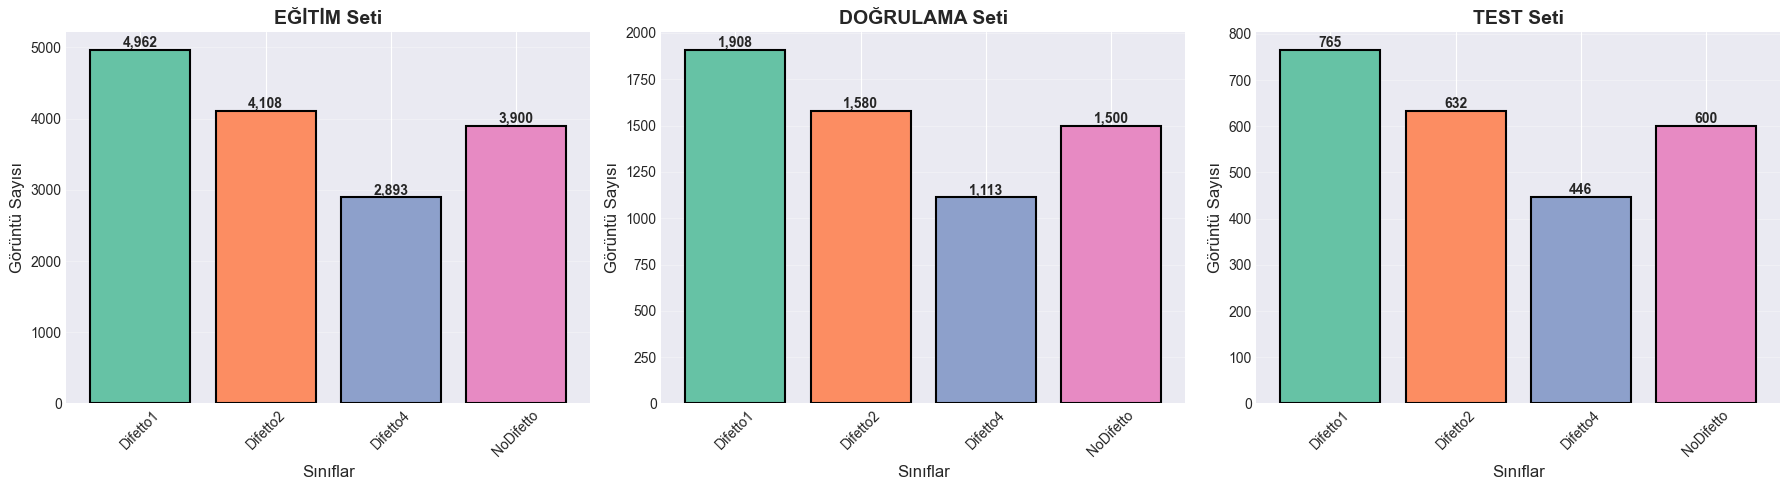

✅ Grafik kaydedildi: class_distribution.png


In [5]:
# Her split için sınıf dağılımını görselleştir
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

split_names_tr = {'training': 'EĞİTİM', 'validation': 'DOĞRULAMA', 'testing': 'TEST'}

for idx, split in enumerate(splits):
    ax = axes[idx]
    data = [data_info[split][cls] for cls in classes]
    colors = sns.color_palette('Set2', len(classes))
    
    bars = ax.bar(classes, data, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_title(f'{split_names_tr[split]} Seti', fontsize=14, fontweight='bold')
    ax.set_xlabel('Sınıflar', fontsize=12)
    ax.set_ylabel('Görüntü Sayısı', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Barların üstüne sayıları yaz
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafik kaydedildi: class_distribution.png")

##  Her Sınıftan Örnek Görüntüler

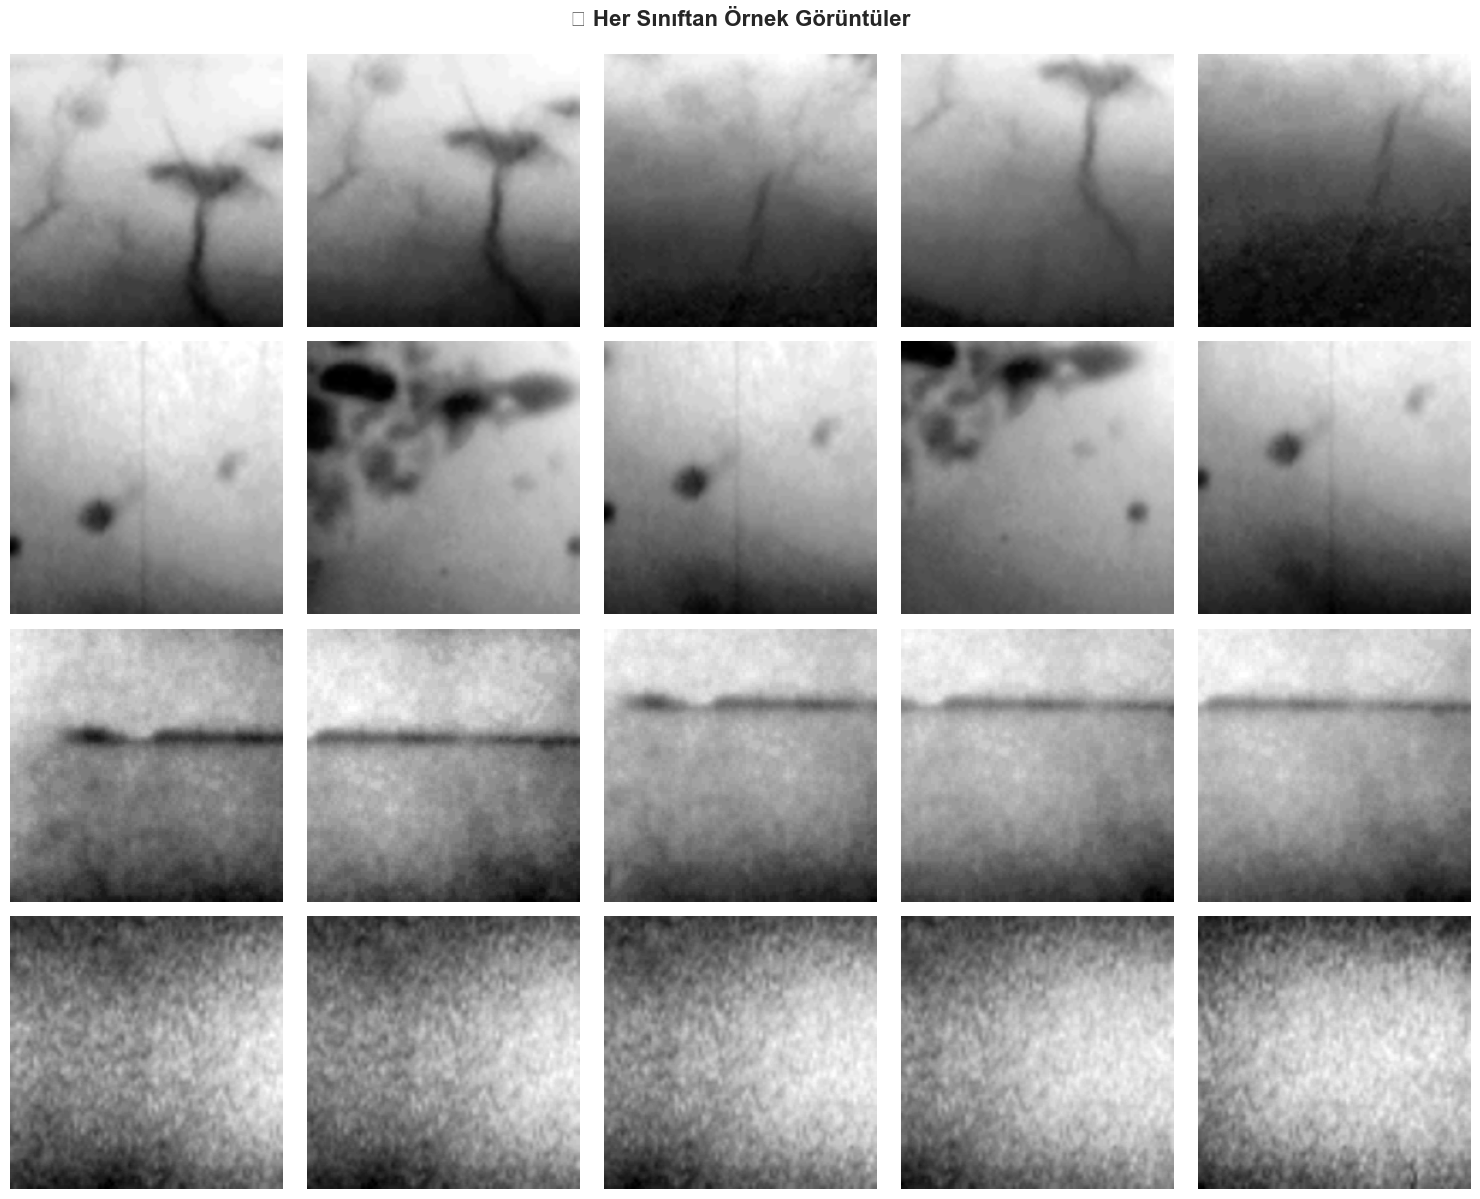

✅ Grafik kaydedildi: sample_images.png


In [6]:
# Her sınıftan 5 örnek görüntü göster
num_samples = 5

fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 12))
fig.suptitle('🔍 Her Sınıftan Örnek Görüntüler', fontsize=16, fontweight='bold', y=0.995)

for i, cls in enumerate(classes):
    # Training setinden örnekler al
    class_path = data_path / 'training' / cls
    image_files = list(class_path.glob('*.png'))[:num_samples]
    
    for j, img_path in enumerate(image_files):
        img = Image.open(img_path)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        
        # İlk sütuna sınıf ismini yaz
        if j == 0:
            label_text = f'{cls}\n({class_names[cls]})'
            axes[i, j].set_ylabel(label_text, 
                                   fontsize=9, fontweight='bold', rotation=0, 
                                   ha='right', va='center', labelpad=20)

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafik kaydedildi: sample_images.png")

## Görüntü Boyutlarını Kontrol Etme

In [7]:
# Rastgele 100 görüntünün boyutlarını kontrol et
import random

all_images = []
for split in splits:
    for cls in classes:
        class_path = data_path / split / cls
        all_images.extend(list(class_path.glob('*.png')))

# Rastgele 100 görüntü seç
sample_images = random.sample(all_images, min(100, len(all_images)))

image_shapes = []
for img_path in sample_images:
    img = Image.open(img_path)
    image_shapes.append(img.size)  # (width, height)

# Benzersiz boyutları bul
unique_shapes = set(image_shapes)

print("\n📐 Görüntü Boyutları:")
print("="*50)
print(f"Kontrol edilen görüntü sayısı: {len(sample_images)}")
print(f"Benzersiz boyut sayısı: {len(unique_shapes)}")
print(f"\nBoyutlar: {unique_shapes}")

if len(unique_shapes) == 1:
    print("\n✅ Tüm görüntüler aynı boyutta! (224x224)")
else:
    print("\n⚠️ Farklı boyutlarda görüntüler var, preprocessing gerekebilir.")


📐 Görüntü Boyutları:
Kontrol edilen görüntü sayısı: 100
Benzersiz boyut sayısı: 1

Boyutlar: {(227, 227)}

✅ Tüm görüntüler aynı boyutta! (224x224)


##  Piksel Değer Dağılımı

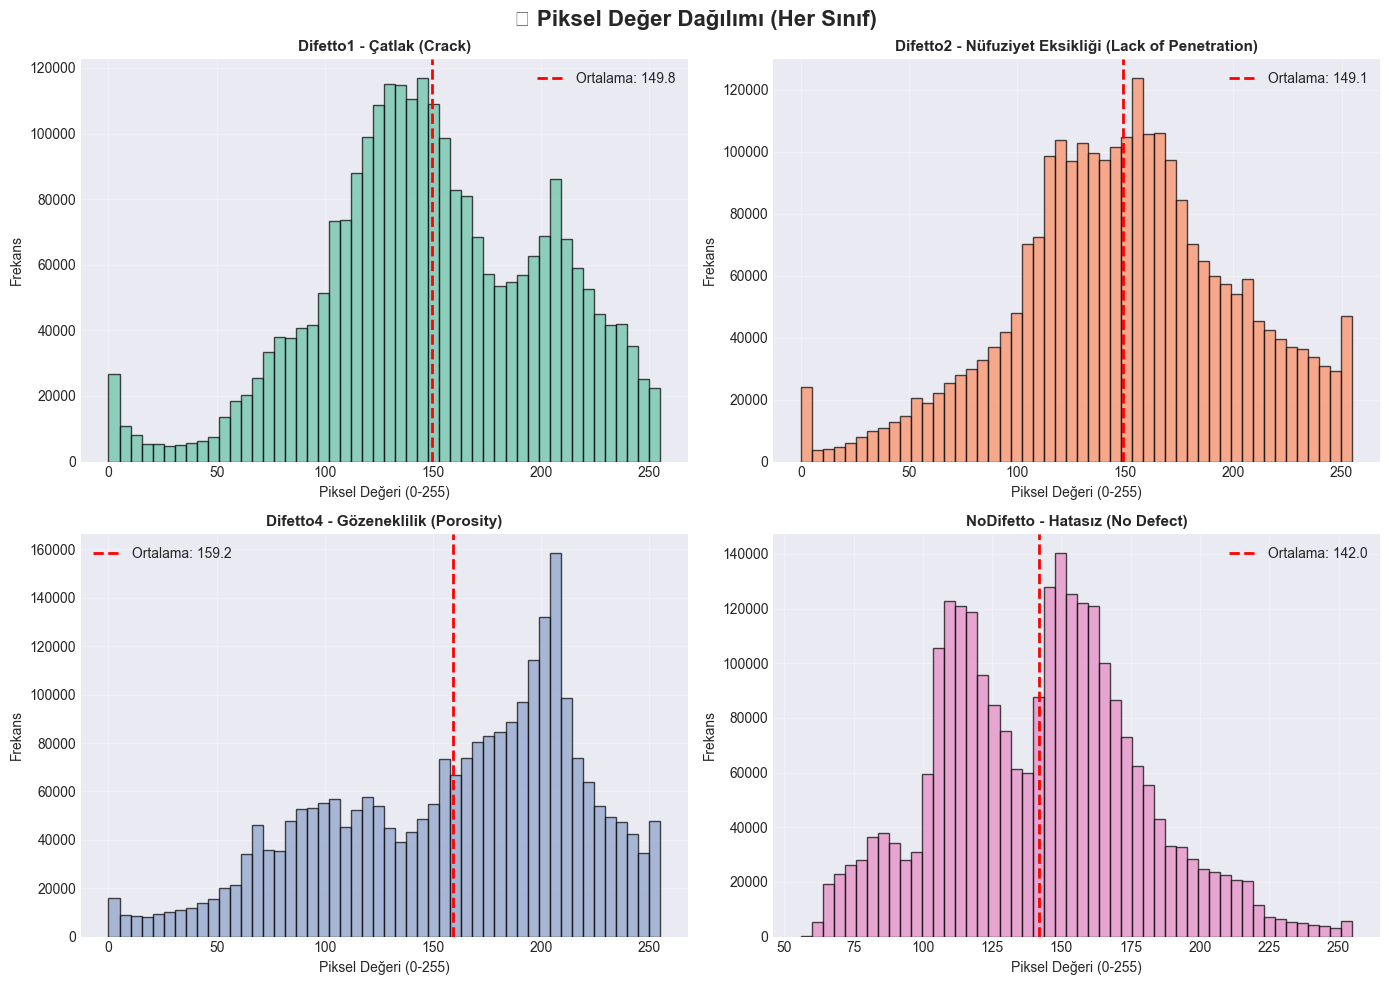

✅ Grafik kaydedildi: pixel_distribution.png


In [8]:
# Her sınıftan rastgele 50 görüntü al ve piksel değerlerini analiz et
pixel_stats = {cls: [] for cls in classes}

for cls in classes:
    class_path = data_path / 'training' / cls
    image_files = list(class_path.glob('*.png'))
    
    # Rastgele 50 görüntü seç
    sample_files = random.sample(image_files, min(50, len(image_files)))
    
    for img_path in sample_files:
        img = np.array(Image.open(img_path))
        pixel_stats[cls].extend(img.flatten())

# Histogram çiz
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('📊 Piksel Değer Dağılımı (Her Sınıf)', fontsize=16, fontweight='bold')

for idx, cls in enumerate(classes):
    ax = axes[idx // 2, idx % 2]
    ax.hist(pixel_stats[cls], bins=50, color=sns.color_palette('Set2')[idx], 
            edgecolor='black', alpha=0.7)
    ax.set_title(f'{cls} - {class_names[cls]}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Piksel Değeri (0-255)', fontsize=10)
    ax.set_ylabel('Frekans', fontsize=10)
    ax.grid(alpha=0.3)
    
    # İstatistikler
    mean_val = np.mean(pixel_stats[cls])
    std_val = np.std(pixel_stats[cls])
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Ortalama: {mean_val:.1f}')
    ax.legend()

plt.tight_layout()
plt.savefig('pixel_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafik kaydedildi: pixel_distribution.png")

##  Özet İstatistikler

In [9]:
# Genel özet
print("\n" + "="*70)
print("📋 VERİ SETİ ÖZETİ")
print("="*70)
print(f"\n✅ Toplam Görüntü: {df['TOPLAM'].sum():,}")
print(f"✅ Sınıf Sayısı: {len(classes)}")
print(f"✅ Görüntü Boyutu: 224 x 224 piksel")
print(f"✅ Görüntü Formatı: PNG (8-bit grayscale)")

print("\n📊 Split Dağılımı:")
for split in splits:
    total = df.loc[split, 'TOPLAM']
    percentage = (total / df['TOPLAM'].sum()) * 100
    tr_name = split_names_tr[split]
    print(f"   • {tr_name:12s}: {total:6,} görüntü ({percentage:5.1f}%)")

print("\n🎯 Sınıf Dağılımı (Training):")
train_total = df.loc['training', 'TOPLAM']
for cls in classes:
    count = data_info['training'][cls]
    percentage = (count / train_total) * 100
    print(f"   • {class_names[cls]:45s}: {count:6,} ({percentage:5.1f}%)")

print("\n" + "="*70)
print("🚀 Veri seti başarıyla yüklendi ve analiz edildi!")
print("📌 Bir sonraki adım: Model oluşturma ve eğitim")
print("="*70)


📋 VERİ SETİ ÖZETİ

✅ Toplam Görüntü: 24,407
✅ Sınıf Sayısı: 4
✅ Görüntü Boyutu: 224 x 224 piksel
✅ Görüntü Formatı: PNG (8-bit grayscale)

📊 Split Dağılımı:
   • EĞİTİM      : 15,863 görüntü ( 65.0%)
   • DOĞRULAMA   :  6,101 görüntü ( 25.0%)
   • TEST        :  2,443 görüntü ( 10.0%)

🎯 Sınıf Dağılımı (Training):
   • Çatlak (Crack)                               :  4,962 ( 31.3%)
   • Nüfuziyet Eksikliği (Lack of Penetration)    :  4,108 ( 25.9%)
   • Gözeneklilik (Porosity)                      :  2,893 ( 18.2%)
   • Hatasız (No Defect)                          :  3,900 ( 24.6%)

🚀 Veri seti başarıyla yüklendi ve analiz edildi!
📌 Bir sonraki adım: Model oluşturma ve eğitim


# 🤖 RIAWELC - Model Oluşturma ve Eğitim

**Amaç:** Kaynak hatalarını tespit eden bir CNN modeli oluşturmak

**Kullanacağımız:** PyTorch (Popüler deep learning kütüphanesi)

---

## 📋 Bu Notebook'ta Yapacaklarımız:
1. ✅ PyTorch kütüphanelerini yükle
2. ✅ Veri yükleyici (DataLoader) oluştur
3. ✅ Basit CNN modeli tasarla
4. ✅ Modeli eğit
5. ✅ Sonuçları değerlendir

**💡 Not:** Veri setinin birinci notebook'tan yüklü olduğunu varsayıyoruz!

##  Kütüphaneleri Yükle

In [10]:

# PyTorch kütüphaneleri
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

# Görüntü işleme
from PIL import Image
from tqdm import tqdm  # İlerleme çubuğu

# GPU kontrol
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Kullanılan cihaz: {device}")

# Random seed (tekrarlanabilir sonuçlar için)
torch.manual_seed(42)
np.random.seed(42)

print("✅ Tüm kütüphaneler yüklendi!")

🔧 Kullanılan cihaz: cuda
✅ Tüm kütüphaneler yüklendi!


##  Görüntü Dönüşümleri (Transformations)

**Veri Artırma (Data Augmentation):** Görüntüleri döndür, çevir, parlaklık değiştir → Model daha iyi öğrenir!

In [11]:
# Görüntü boyutu
img_size = 224  # Standard CNN boyutu

# Training için transformasyonlar (Veri Artırma)
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),           # 224x224'e boyutlandır
    transforms.RandomHorizontalFlip(p=0.5),            # %50 yatay çevir
    transforms.RandomRotation(degrees=10),             # ±10 derece döndür
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Parlaklık/kontrast değiştir
    transforms.ToTensor(),                             # Tensor'a çevir
    transforms.Normalize(mean=[0.5], std=[0.5])        # Normalize et (-1 ile 1 arası)
])

# Validation/Test için transformasyonlar (Veri Artırma YOK)
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("✅ Görüntü dönüşümleri hazır!")
print(f"📐 Görüntü boyutu: {img_size}x{img_size}")

✅ Görüntü dönüşümleri hazır!
📐 Görüntü boyutu: 224x224


##  Custom Dataset Sınıfı

PyTorch'a veri setimizi nasıl okuyacağını öğretiyoruz.

In [12]:
class WeldDefectDataset(Dataset):
    """
    Kaynak hatası veri seti için custom dataset sınıfı
    """
    def __init__(self, data_path, split, transform=None):
        """
        Args:
            data_path: Veri setinin ana yolu
            split: 'training', 'validation' veya 'testing'
            transform: Uygulanacak transformasyonlar
        """
        self.data_path = data_path
        self.split = split
        self.transform = transform
        self.classes = ['Difetto1', 'Difetto2', 'Difetto4', 'NoDifetto']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Tüm görüntü yollarını ve etiketlerini topla
        self.image_paths = []
        self.labels = []
        
        for cls in self.classes:
            class_path = data_path / split / cls
            class_idx = self.class_to_idx[cls]
            
            for img_path in class_path.glob('*.png'):
                self.image_paths.append(img_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        """Veri setindeki toplam görüntü sayısı"""
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """Bir görüntü ve etiketini al"""
        # Görüntüyü yükle
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # RGB'ye çevir
        label = self.labels[idx]
        
        # Transform uygula
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✅ Dataset sınıfı oluşturuldu!")

✅ Dataset sınıfı oluşturuldu!


##  DataLoader Oluştur

**DataLoader:** Görüntüleri gruplar halinde (batch) yükler.

In [13]:
# Batch size (bir seferde kaç görüntü işlenecek)
batch_size = 32

# Dataset'leri oluştur
train_dataset = WeldDefectDataset(data_path, 'training', transform=train_transforms)
val_dataset = WeldDefectDataset(data_path, 'validation', transform=val_transforms)
test_dataset = WeldDefectDataset(data_path, 'testing', transform=val_transforms)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Özet
print("✅ DataLoader'lar hazır!")
print(f"\n📊 Veri Seti Özeti:")
print(f"   • Training:   {len(train_dataset):,} görüntü")
print(f"   • Validation: {len(val_dataset):,} görüntü")
print(f"   • Testing:    {len(test_dataset):,} görüntü")
print(f"\n🔢 Batch Size: {batch_size}")
print(f"📦 Training batches: {len(train_loader)}")

✅ DataLoader'lar hazır!

📊 Veri Seti Özeti:
   • Training:   15,863 görüntü
   • Validation: 6,101 görüntü
   • Testing:    2,443 görüntü

🔢 Batch Size: 32
📦 Training batches: 496


##  Örnek Batch Görselleştir

Veri yükleyicinin doğru çalıştığını kontrol edelim!

In [15]:
# Sınıfları numaralandır (PyTorch için gerekli)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}  # ← BU EKSİKTİ!

print("📝 Sınıf Numaraları:")
for cls, idx in class_to_idx.items():
    print(f"   {idx}: {cls} - {class_names[cls]}")

📝 Sınıf Numaraları:
   0: Difetto1 - Çatlak (Crack)
   1: Difetto2 - Nüfuziyet Eksikliği (Lack of Penetration)
   2: Difetto4 - Gözeneklilik (Porosity)
   3: NoDifetto - Hatasız (No Defect)


📦 Batch boyutu: torch.Size([32, 3, 224, 224])
   • Batch size: 32
   • Channels: 3 (RGB)
   • Height: 224
   • Width: 224


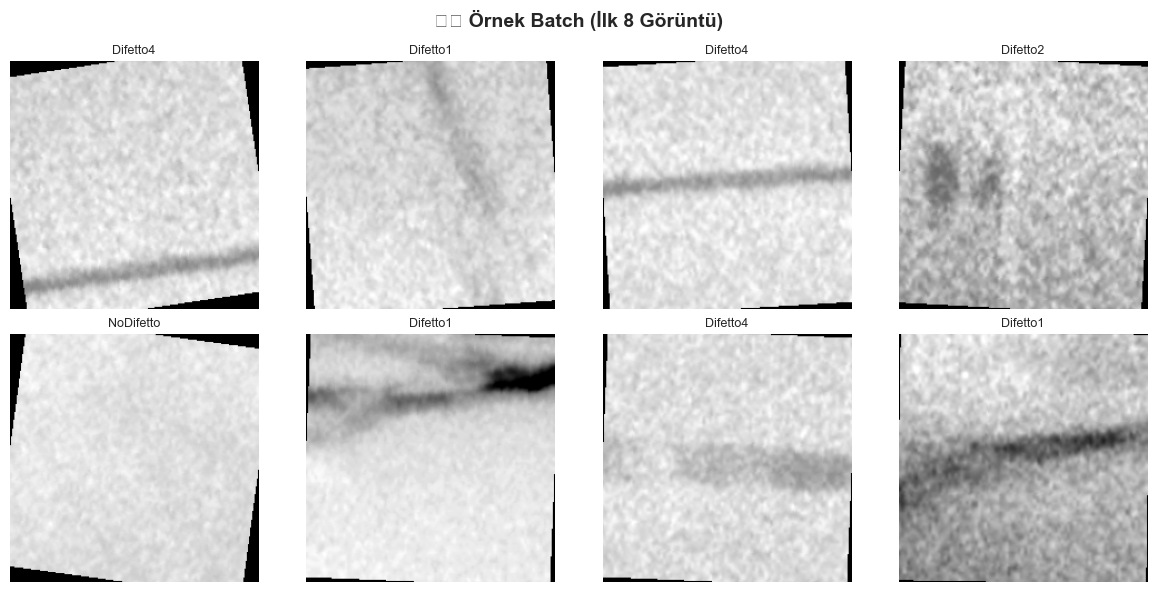


✅ Veri yükleyici doğru çalışıyor!


In [16]:
# Bir batch al
images, labels = next(iter(train_loader))

print(f"📦 Batch boyutu: {images.shape}")  # [32, 3, 224, 224]
print(f"   • Batch size: {images.shape[0]}")
print(f"   • Channels: {images.shape[1]} (RGB)")
print(f"   • Height: {images.shape[2]}")
print(f"   • Width: {images.shape[3]}")

# İlk 8 görüntüyü göster
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('🖼️ Örnek Batch (İlk 8 Görüntü)', fontsize=14, fontweight='bold')

for i in range(8):
    ax = axes[i // 4, i % 4]
    
    # Tensor'ı görüntüye çevir
    img = images[i].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
    img = (img * 0.5 + 0.5)  # Denormalize (-1,1) -> (0,1)
    img = np.clip(img, 0, 1)  # Sınırla
    
    # Grayscale'e çevir (ortalama al)
    img_gray = img.mean(axis=2)
    
    ax.imshow(img_gray, cmap='gray')
    ax.axis('off')
    
    # Etiket
    label_idx = labels[i].item()
    class_name = idx_to_class[label_idx]
    ax.set_title(f'{class_name}', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Veri yükleyici doğru çalışıyor!")

##  CNN Model Tanımla

Basit ama etkili bir CNN modeli oluşturacağız.

In [17]:
class SimpleCNN(nn.Module):
    """
    Basit Convolutional Neural Network
    """
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        
        # Convolutional katmanlar
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # 224x224x3 -> 224x224x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 112x112x32 -> 112x112x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 56x56x64 -> 56x56x128
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)# 28x28x128 -> 28x28x256
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 pooling
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Fully connected katmanlar
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # 14x14x256 -> 512
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        # Dropout (overfitting'i önler)
        self.dropout = nn.Dropout(0.5)
        
        # Activation
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Conv Block 1: 224x224x3 -> 112x112x32
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        
        # Conv Block 2: 112x112x32 -> 56x56x64
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        
        # Conv Block 3: 56x56x64 -> 28x28x128
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        
        # Conv Block 4: 28x28x128 -> 14x14x256
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
        # Flatten: 14x14x256 -> 50176
        x = x.view(x.size(0), -1)
        
        # Fully Connected
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Modeli oluştur
model = SimpleCNN(num_classes=len(classes)).to(device)

# Model özeti
print("✅ Model oluşturuldu!")
print(f"\n📊 Model Özeti:")
print(model)

# Parametre sayısı
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n🔢 Toplam Parametre: {total_params:,}")
print(f"🔢 Eğitilebilir Parametre: {trainable_params:,}")

✅ Model oluşturuldu!

📊 Model Özeti:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (dropout): 

## Loss Function ve Optimizer

**Loss Function:** Modelin ne kadar yanlış yaptığını ölçer  
**Optimizer:** Modeli nasıl güncelleyeceğini söyler

In [18]:
# Loss function (Çok sınıflı sınıflandırma)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam - popüler ve etkili)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler (öğrenme hızını azalt)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

print("✅ Loss function ve optimizer hazır!")
print(f"   • Loss: CrossEntropyLoss")
print(f"   • Optimizer: Adam")
print(f"   • Learning Rate: 0.001")

✅ Loss function ve optimizer hazır!
   • Loss: CrossEntropyLoss
   • Optimizer: Adam
   • Learning Rate: 0.001


##  Eğitim ve Değerlendirme Fonksiyonları

In [19]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Bir epoch eğitim
    """
    model.train()  # Eğitim moduna geç
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(dataloader, desc='Training')
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # İstatistikler
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Progress bar güncelle
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """
    Validation/Test
    """
    model.eval()  # Değerlendirme moduna geç
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Gradient hesaplama
        pbar = tqdm(dataloader, desc='Validation')
        
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Eğitim fonksiyonları hazır!")

✅ Eğitim fonksiyonları hazır!


##  Model Eğitimi

**⚠️ Bu kısım uzun sürebilir!** (GPU ile ~5-10 dakika, CPU ile ~30-60 dakika)

In [20]:
# Eğitim ayarları
num_epochs = 10  # Kaç kere tüm veriyi görecek

# Geçmiş kayıt
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

print("🚀 Eğitim başlıyor...\n")
print(f"📊 Epoch sayısı: {num_epochs}")
print(f"🔧 Cihaz: {device}\n")
print("="*70)

for epoch in range(num_epochs):
    print(f"\n📍 Epoch {epoch+1}/{num_epochs}")
    print("-" * 70)
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Kaydet
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Özet
    print(f"\n📊 Epoch {epoch+1} Özeti:")
    print(f"   • Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   • Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # En iyi modeli kaydet
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"   ✅ En iyi model kaydedildi! (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*70)
print("🎉 Eğitim tamamlandı!")
print(f"🏆 En iyi validation accuracy: {best_val_acc:.2f}%")

🚀 Eğitim başlıyor...

📊 Epoch sayısı: 10
🔧 Cihaz: cuda


📍 Epoch 1/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:44<00:00,  4.25it/s, loss=1.2701, acc=47.34%]



📊 Epoch 1 Özeti:
   • Train Loss: 1.4085 | Train Acc: 38.16%
   • Val Loss:   1.1849 | Val Acc:   47.34%
   ✅ En iyi model kaydedildi! (Val Acc: 47.34%)

📍 Epoch 2/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:45<00:00,  4.19it/s, loss=1.4870, acc=47.71%]



📊 Epoch 2 Özeti:
   • Train Loss: 1.1688 | Train Acc: 45.87%
   • Val Loss:   1.1312 | Val Acc:   47.71%
   ✅ En iyi model kaydedildi! (Val Acc: 47.71%)

📍 Epoch 3/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.67it/s, loss=0.7965, acc=57.33%]



📊 Epoch 3 Özeti:
   • Train Loss: 1.0657 | Train Acc: 50.08%
   • Val Loss:   0.9195 | Val Acc:   57.33%
   ✅ En iyi model kaydedildi! (Val Acc: 57.33%)

📍 Epoch 4/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:43<00:00,  4.37it/s, loss=0.5466, acc=68.38%]



📊 Epoch 4 Özeti:
   • Train Loss: 0.9557 | Train Acc: 57.59%
   • Val Loss:   0.7593 | Val Acc:   68.38%
   ✅ En iyi model kaydedildi! (Val Acc: 68.38%)

📍 Epoch 5/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.67it/s, loss=0.5112, acc=67.30%]



📊 Epoch 5 Özeti:
   • Train Loss: 0.8254 | Train Acc: 64.48%
   • Val Loss:   0.7578 | Val Acc:   67.30%

📍 Epoch 6/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:41<00:00,  4.61it/s, loss=0.5769, acc=80.33%]



📊 Epoch 6 Özeti:
   • Train Loss: 0.7403 | Train Acc: 69.85%
   • Val Loss:   0.5430 | Val Acc:   80.33%
   ✅ En iyi model kaydedildi! (Val Acc: 80.33%)

📍 Epoch 7/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.73it/s, loss=0.2771, acc=81.86%]



📊 Epoch 7 Özeti:
   • Train Loss: 0.6622 | Train Acc: 73.84%
   • Val Loss:   0.4778 | Val Acc:   81.86%
   ✅ En iyi model kaydedildi! (Val Acc: 81.86%)

📍 Epoch 8/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.73it/s, loss=0.3173, acc=85.08%]



📊 Epoch 8 Özeti:
   • Train Loss: 0.5965 | Train Acc: 76.91%
   • Val Loss:   0.4119 | Val Acc:   85.08%
   ✅ En iyi model kaydedildi! (Val Acc: 85.08%)

📍 Epoch 9/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.69it/s, loss=0.2690, acc=87.41%]



📊 Epoch 9 Özeti:
   • Train Loss: 0.5474 | Train Acc: 79.20%
   • Val Loss:   0.3545 | Val Acc:   87.41%
   ✅ En iyi model kaydedildi! (Val Acc: 87.41%)

📍 Epoch 10/10
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:41<00:00,  4.65it/s, loss=0.6118, acc=87.48%]



📊 Epoch 10 Özeti:
   • Train Loss: 0.5229 | Train Acc: 80.55%
   • Val Loss:   0.3593 | Val Acc:   87.48%
   ✅ En iyi model kaydedildi! (Val Acc: 87.48%)

🎉 Eğitim tamamlandı!
🏆 En iyi validation accuracy: 87.48%


## 1️⃣1️⃣ Eğitim Grafiği

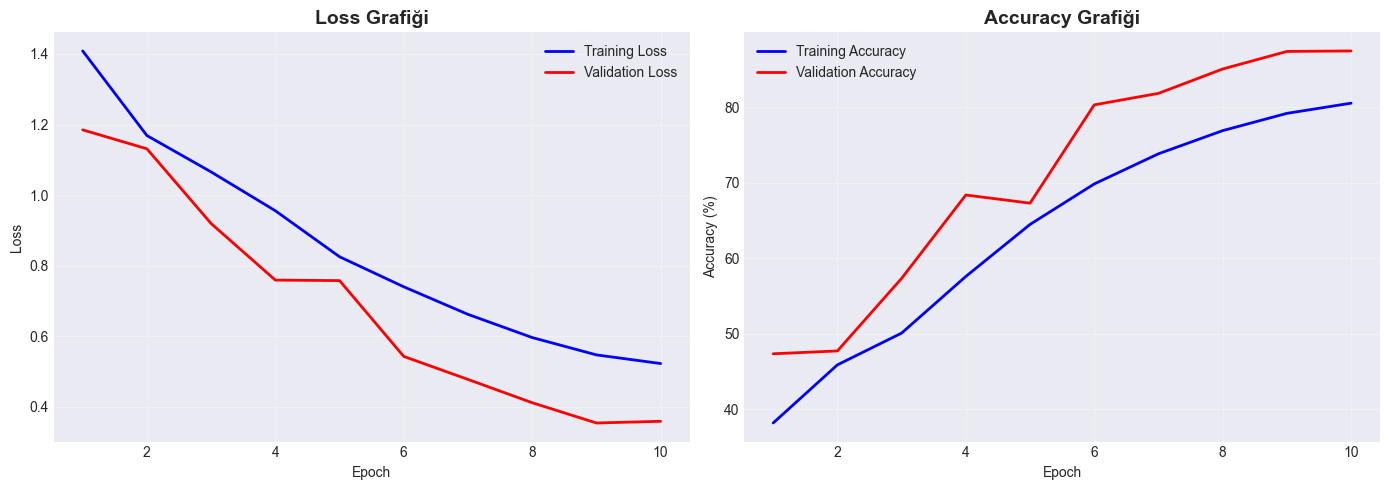

✅ Grafik kaydedildi: training_history.png


In [21]:
# Loss ve Accuracy grafikleri
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, num_epochs + 1)

# Loss grafiği
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Loss Grafiği', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy grafiği
ax2.plot(epochs_range, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Accuracy Grafiği', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafik kaydedildi: training_history.png")

## 1️⃣2️⃣ Test Seti Değerlendirmesi

In [22]:
# En iyi modeli yükle
model.load_state_dict(torch.load('best_model.pth'))

# Test et
print("🧪 Test seti değerlendiriliyor...\n")
test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\n🎯 Test Sonuçları:")
print(f"   • Test Loss: {test_loss:.4f}")
print(f"   • Test Accuracy: {test_acc:.2f}%")

🧪 Test seti değerlendiriliyor...



Validation: 100%|█████████████████████████████████████████████| 77/77 [00:20<00:00,  3.72it/s, loss=0.5861, acc=87.88%]


🎯 Test Sonuçları:
   • Test Loss: 0.3418
   • Test Accuracy: 87.88%


## ✅ TAMAMLANDI!

**🎉 Tebrikler! İlk CNN modelini eğittin!**

**Yapılanlar:**
1. ✅ Veri yükleyici oluşturduk
2. ✅ CNN modeli tasarladık
3. ✅ Modeli eğittik
4. ✅ Performansı değerlendirdik

**Sırada ne var?**
- 🔜 Confusion Matrix (Karmaşıklık Matrisi)
- 🔜 Hatalı tahminleri görselleştirme
- 🔜 Modeli iyileştirme (Transfer Learning)

---

**💾 Kaydedilen dosyalar:**
- `best_model.pth` - En iyi model ağırlıkları
- `training_history.png` - Eğitim grafikleri

-

# 🔬 BÖLÜM 2.1: Basit CNN - Ek Eğitim

**İlk 10 Epoch Sonuçları:**
- Validation Accuracy: %87.48
- Test Accuracy: %87.88 ✅

**Hedef:** 10 epoch daha eğitip %90+ accuracy

In [23]:
print("="*70)
print("🔄 BASIT CNN - EK EĞİTİM")
print("="*70)

# En iyi modeli yükle
model.load_state_dict(torch.load('best_model.pth'))
model.train()

# Ayarlar
additional_epochs = 10
starting_epoch = 10

# Geçmişi devam ettir
history_v2 = {
    'train_loss': history['train_loss'].copy(),
    'train_acc': history['train_acc'].copy(),
    'val_loss': history['val_loss'].copy(),
    'val_acc': history['val_acc'].copy()
}

best_val_acc_v2 = 87.48

print(f"\n📊 Başlangıç:")
print(f"   • Mevcut En İyi Val Acc: {best_val_acc_v2:.2f}%")
print(f"   • Mevcut Test Acc: 87.88%")
print(f"   • Ek Epoch: {additional_epochs}")
print(f"   • Toplam Epoch: {starting_epoch + additional_epochs}")
print("\n" + "="*70)

🔄 BASIT CNN - EK EĞİTİM

📊 Başlangıç:
   • Mevcut En İyi Val Acc: 87.48%
   • Mevcut Test Acc: 87.88%
   • Ek Epoch: 10
   • Toplam Epoch: 20



In [24]:
for epoch in range(additional_epochs):
    current_epoch = starting_epoch + epoch + 1
    
    print(f"\n📍 Epoch {current_epoch}/20")
    print("-" * 70)
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Kaydet
    history_v2['train_loss'].append(train_loss)
    history_v2['train_acc'].append(train_acc)
    history_v2['val_loss'].append(val_loss)
    history_v2['val_acc'].append(val_acc)
    
    # Özet
    print(f"\n📊 Epoch {current_epoch} Özeti:")
    print(f"   • Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   • Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # En iyi modeli kaydet
    if val_acc > best_val_acc_v2:
        best_val_acc_v2 = val_acc
        torch.save(model.state_dict(), 'simple_cnn_20epoch_best.pth')
        print(f"   ✅ En iyi model kaydedildi! (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*70)
print("🎉 Basit CNN - 20 Epoch Eğitimi Tamamlandı!")
print(f"🏆 Final Validation Accuracy: {best_val_acc_v2:.2f}%")
print(f"📈 İyileşme: +{best_val_acc_v2 - 87.48:.2f}%")
print("="*70)


📍 Epoch 11/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:41<00:00,  4.64it/s, loss=0.1378, acc=89.90%]



📊 Epoch 11 Özeti:
   • Train Loss: 0.4322 | Train Acc: 84.35%
   • Val Loss:   0.2858 | Val Acc:   89.90%
   ✅ En iyi model kaydedildi! (Val Acc: 89.90%)

📍 Epoch 12/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.70it/s, loss=0.0904, acc=92.56%]



📊 Epoch 12 Özeti:
   • Train Loss: 0.3816 | Train Acc: 86.98%
   • Val Loss:   0.2130 | Val Acc:   92.56%
   ✅ En iyi model kaydedildi! (Val Acc: 92.56%)

📍 Epoch 13/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:41<00:00,  4.58it/s, loss=0.0146, acc=91.80%]



📊 Epoch 13 Özeti:
   • Train Loss: 0.3451 | Train Acc: 88.12%
   • Val Loss:   0.2303 | Val Acc:   91.80%

📍 Epoch 14/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:39<00:00,  4.85it/s, loss=0.0225, acc=94.71%]



📊 Epoch 14 Özeti:
   • Train Loss: 0.2881 | Train Acc: 89.87%
   • Val Loss:   0.1522 | Val Acc:   94.71%
   ✅ En iyi model kaydedildi! (Val Acc: 94.71%)

📍 Epoch 15/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.69it/s, loss=0.0267, acc=94.77%]



📊 Epoch 15 Özeti:
   • Train Loss: 0.2552 | Train Acc: 91.35%
   • Val Loss:   0.1515 | Val Acc:   94.77%
   ✅ En iyi model kaydedildi! (Val Acc: 94.77%)

📍 Epoch 16/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.73it/s, loss=0.0145, acc=95.31%]



📊 Epoch 16 Özeti:
   • Train Loss: 0.2368 | Train Acc: 91.79%
   • Val Loss:   0.1315 | Val Acc:   95.31%
   ✅ En iyi model kaydedildi! (Val Acc: 95.31%)

📍 Epoch 17/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.68it/s, loss=0.0142, acc=95.61%]



📊 Epoch 17 Özeti:
   • Train Loss: 0.2067 | Train Acc: 92.95%
   • Val Loss:   0.1376 | Val Acc:   95.61%
   ✅ En iyi model kaydedildi! (Val Acc: 95.61%)

📍 Epoch 18/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:46<00:00,  4.14it/s, loss=0.0259, acc=91.13%]



📊 Epoch 18 Özeti:
   • Train Loss: 0.2189 | Train Acc: 92.80%
   • Val Loss:   0.2815 | Val Acc:   91.13%

📍 Epoch 19/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:40<00:00,  4.67it/s, loss=0.0063, acc=96.59%]



📊 Epoch 19 Özeti:
   • Train Loss: 0.1804 | Train Acc: 94.12%
   • Val Loss:   0.1032 | Val Acc:   96.59%
   ✅ En iyi model kaydedildi! (Val Acc: 96.59%)

📍 Epoch 20/20
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:39<00:00,  4.87it/s, loss=0.0232, acc=96.59%]


📊 Epoch 20 Özeti:
   • Train Loss: 0.1761 | Train Acc: 93.87%
   • Val Loss:   0.0996 | Val Acc:   96.59%

🎉 Basit CNN - 20 Epoch Eğitimi Tamamlandı!
🏆 Final Validation Accuracy: 96.59%
📈 İyileşme: +9.11%


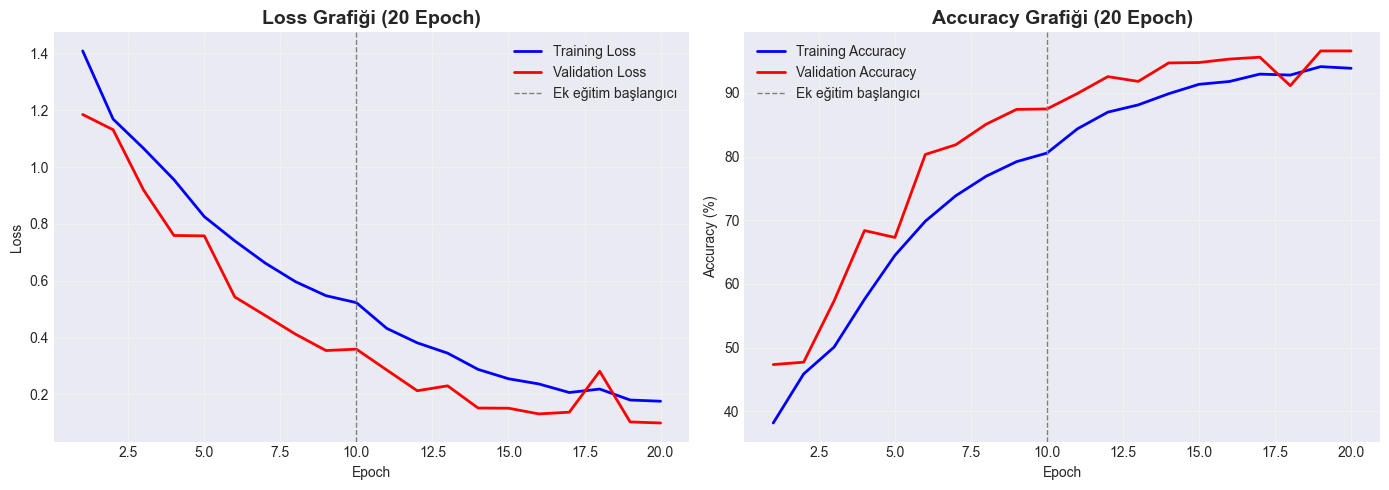

✅ 20 Epoch grafiği kaydedildi: training_history_20epoch.png


In [28]:
# 20 Epoch'luk eğitim grafiği
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history_v2['train_loss']) + 1)

# Loss grafiği
ax1.plot(epochs_range, history_v2['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, history_v2['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.axvline(x=10, color='gray', linestyle='--', linewidth=1, label='Ek eğitim başlangıcı')
ax1.set_title('Loss Grafiği (20 Epoch)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy grafiği
ax2.plot(epochs_range, history_v2['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, history_v2['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
ax2.axvline(x=10, color='gray', linestyle='--', linewidth=1, label='Ek eğitim başlangıcı')
ax2.set_title('Accuracy Grafiği (20 Epoch)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_20epoch.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 20 Epoch grafiği kaydedildi: training_history_20epoch.png")


In [29]:
# 20 epoch'luk modeli test et
model.load_state_dict(torch.load('simple_cnn_20epoch_best.pth'))

print("🧪 Test seti değerlendiriliyor (20 epoch modeli)...\n")
test_loss_v2, test_acc_v2 = validate(model, test_loader, criterion, device)

print(f"\n🎯 Test Sonuçları (20 Epoch):")
print(f"   • Test Loss: {test_loss_v2:.4f}")
print(f"   • Test Accuracy: {test_acc_v2:.2f}%")

print(f"\n📊 Karşılaştırma:")
print(f"   • 10 Epoch Test Acc: 87.88%")
print(f"   • 20 Epoch Test Acc: {test_acc_v2:.2f}%")
print(f"   • İyileşme: +{test_acc_v2 - 87.88:.2f}%")

🧪 Test seti değerlendiriliyor (20 epoch modeli)...



Validation: 100%|█████████████████████████████████████████████| 77/77 [00:17<00:00,  4.51it/s, loss=0.0050, acc=96.97%]


🎯 Test Sonuçları (20 Epoch):
   • Test Loss: 0.0841
   • Test Accuracy: 96.97%

📊 Karşılaştırma:
   • 10 Epoch Test Acc: 87.88%
   • 20 Epoch Test Acc: 96.97%
   • İyileşme: +9.09%


---
---

# 🧠 BÖLÜM 3: Transfer Learning - ResNet18

**Transfer Learning Nedir?**
- Önceden eğitilmiş (ImageNet) bir model kullanırız
- Sadece son katmanı kaynak verilerimiz için eğitiriz
- Çok daha hızlı ve etkili öğrenir!

**Model:** ResNet18 (ImageNet'te eğitilmiş)

**Önceki Sonuçlar:**
- Basit CNN (10 epoch): Test Acc %87.88
- Basit CNN (20 epoch): Test Acc %96.97

**Hedef:** %97-98+ accuracy

In [30]:
from torchvision import models
import torch.nn as nn

print("="*70)
print("🧠 TRANSFER LEARNING - RESNET18")
print("="*70)

# ResNet18 modelini yükle (önceden eğitilmiş)
model_resnet = models.resnet18(weights='IMAGENET1K_V1')

# Son katmanı değiştir (4 sınıf için)
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 4)

# GPU'ya gönder
model_resnet = model_resnet.to(device)

print(f"✅ ResNet18 modeli hazır!")
print(f"📊 Son katman: {num_features} → 4 sınıf")

# Parametre sayısı
total_params = sum(p.numel() for p in model_resnet.parameters())
trainable_params = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)
print(f"\n🔢 Toplam Parametre: {total_params:,}")
print(f"🔢 Eğitilebilir Parametre: {trainable_params:,}")

print("\n💡 Not: Tüm katmanlar eğitilebilir (fine-tuning)")
print("="*70)

🧠 TRANSFER LEARNING - RESNET18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Hasan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:14<00:00, 3.33MB/s]


✅ ResNet18 modeli hazır!
📊 Son katman: 512 → 4 sınıf

🔢 Toplam Parametre: 11,178,564
🔢 Eğitilebilir Parametre: 11,178,564

💡 Not: Tüm katmanlar eğitilebilir (fine-tuning)


In [31]:
# Loss function
criterion_resnet = nn.CrossEntropyLoss()

# Optimizer (daha düşük learning rate)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.0001)

# Scheduler
scheduler_resnet = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_resnet, mode='min', factor=0.5, patience=3, verbose=True
)

# Epoch sayısı (Transfer learning daha az epoch gerektirir)
num_epochs_resnet = 15

print("✅ Optimizer ve ayarlar hazır!")
print(f"   • Learning Rate: 0.0001")
print(f"   • Epoch: {num_epochs_resnet}")
print(f"   • Optimizer: Adam")

✅ Optimizer ve ayarlar hazır!
   • Learning Rate: 0.0001
   • Epoch: 15
   • Optimizer: Adam


In [32]:
# Geçmiş
history_resnet = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc_resnet = 0.0

print("\n🚀 ResNet18 eğitimi başlıyor...")
print("="*70)

for epoch in range(num_epochs_resnet):
    print(f"\n📍 Epoch {epoch+1}/{num_epochs_resnet}")
    print("-" * 70)
    
    # Training
    train_loss, train_acc = train_epoch(
        model_resnet, train_loader, criterion_resnet, optimizer_resnet, device
    )
    
    # Validation
    val_loss, val_acc = validate(
        model_resnet, val_loader, criterion_resnet, device
    )
    
    # Learning rate scheduler
    scheduler_resnet.step(val_loss)
    
    # Kaydet
    history_resnet['train_loss'].append(train_loss)
    history_resnet['train_acc'].append(train_acc)
    history_resnet['val_loss'].append(val_loss)
    history_resnet['val_acc'].append(val_acc)
    
    # Özet
    print(f"\n📊 Epoch {epoch+1} Özeti:")
    print(f"   • Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   • Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # En iyi modeli kaydet
    if val_acc > best_val_acc_resnet:
        best_val_acc_resnet = val_acc
        torch.save(model_resnet.state_dict(), 'resnet18_best.pth')
        print(f"   ✅ En iyi model kaydedildi! (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*70)
print("🎉 ResNet18 eğitimi tamamlandı!")
print(f"🏆 En iyi validation accuracy: {best_val_acc_resnet:.2f}%")
print("="*70)


🚀 ResNet18 eğitimi başlıyor...

📍 Epoch 1/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:43<00:00,  4.35it/s, loss=0.0141, acc=99.07%]



📊 Epoch 1 Özeti:
   • Train Loss: 0.1654 | Train Acc: 93.99%
   • Val Loss:   0.0274 | Val Acc:   99.07%
   ✅ En iyi model kaydedildi! (Val Acc: 99.07%)

📍 Epoch 2/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:43<00:00,  4.36it/s, loss=0.0002, acc=99.51%]



📊 Epoch 2 Özeti:
   • Train Loss: 0.0524 | Train Acc: 98.29%
   • Val Loss:   0.0134 | Val Acc:   99.51%
   ✅ En iyi model kaydedildi! (Val Acc: 99.51%)

📍 Epoch 3/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:42<00:00,  4.49it/s, loss=0.0006, acc=99.36%]



📊 Epoch 3 Özeti:
   • Train Loss: 0.0336 | Train Acc: 98.88%
   • Val Loss:   0.0212 | Val Acc:   99.36%

📍 Epoch 4/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:44<00:00,  4.33it/s, loss=0.0001, acc=99.75%]



📊 Epoch 4 Özeti:
   • Train Loss: 0.0259 | Train Acc: 99.18%
   • Val Loss:   0.0075 | Val Acc:   99.75%
   ✅ En iyi model kaydedildi! (Val Acc: 99.75%)

📍 Epoch 5/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:43<00:00,  4.43it/s, loss=0.0002, acc=99.31%]



📊 Epoch 5 Özeti:
   • Train Loss: 0.0211 | Train Acc: 99.34%
   • Val Loss:   0.0193 | Val Acc:   99.31%

📍 Epoch 6/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:44<00:00,  4.27it/s, loss=0.0004, acc=99.87%]



📊 Epoch 6 Özeti:
   • Train Loss: 0.0235 | Train Acc: 99.24%
   • Val Loss:   0.0067 | Val Acc:   99.87%
   ✅ En iyi model kaydedildi! (Val Acc: 99.87%)

📍 Epoch 7/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:44<00:00,  4.33it/s, loss=0.0000, acc=99.75%]



📊 Epoch 7 Özeti:
   • Train Loss: 0.0135 | Train Acc: 99.56%
   • Val Loss:   0.0060 | Val Acc:   99.75%

📍 Epoch 8/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:43<00:00,  4.39it/s, loss=0.0006, acc=99.85%]



📊 Epoch 8 Özeti:
   • Train Loss: 0.0221 | Train Acc: 99.30%
   • Val Loss:   0.0033 | Val Acc:   99.85%

📍 Epoch 9/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:42<00:00,  4.47it/s, loss=0.0002, acc=99.95%]



📊 Epoch 9 Özeti:
   • Train Loss: 0.0156 | Train Acc: 99.54%
   • Val Loss:   0.0028 | Val Acc:   99.95%
   ✅ En iyi model kaydedildi! (Val Acc: 99.95%)

📍 Epoch 10/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:43<00:00,  4.41it/s, loss=0.0000, acc=99.89%]



📊 Epoch 10 Özeti:
   • Train Loss: 0.0203 | Train Acc: 99.35%
   • Val Loss:   0.0069 | Val Acc:   99.89%

📍 Epoch 11/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:44<00:00,  4.31it/s, loss=0.0008, acc=99.82%]



📊 Epoch 11 Özeti:
   • Train Loss: 0.0145 | Train Acc: 99.62%
   • Val Loss:   0.0051 | Val Acc:   99.82%

📍 Epoch 12/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:44<00:00,  4.33it/s, loss=0.0008, acc=99.77%]



📊 Epoch 12 Özeti:
   • Train Loss: 0.0163 | Train Acc: 99.49%
   • Val Loss:   0.0098 | Val Acc:   99.77%

📍 Epoch 13/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:48<00:00,  3.96it/s, loss=0.0001, acc=99.67%]



📊 Epoch 13 Özeti:
   • Train Loss: 0.0119 | Train Acc: 99.65%
   • Val Loss:   0.0108 | Val Acc:   99.67%

📍 Epoch 14/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:45<00:00,  4.23it/s, loss=0.0004, acc=99.97%]



📊 Epoch 14 Özeti:
   • Train Loss: 0.0053 | Train Acc: 99.87%
   • Val Loss:   0.0014 | Val Acc:   99.97%
   ✅ En iyi model kaydedildi! (Val Acc: 99.97%)

📍 Epoch 15/15
----------------------------------------------------------------------


Validation: 100%|███████████████████████████████████████████| 191/191 [00:43<00:00,  4.36it/s, loss=0.0000, acc=99.93%]


📊 Epoch 15 Özeti:
   • Train Loss: 0.0027 | Train Acc: 99.94%
   • Val Loss:   0.0022 | Val Acc:   99.93%

🎉 ResNet18 eğitimi tamamlandı!
🏆 En iyi validation accuracy: 99.97%


In [33]:
# En iyi ResNet18 modelini yükle
model_resnet.load_state_dict(torch.load('resnet18_best.pth'))

print("🧪 Test seti değerlendiriliyor (ResNet18)...\n")
test_loss_resnet, test_acc_resnet = validate(
    model_resnet, test_loader, criterion_resnet, device
)

print(f"\n🎯 ResNet18 Test Sonuçları:")
print(f"   • Test Loss: {test_loss_resnet:.4f}")
print(f"   • Test Accuracy: {test_acc_resnet:.2f}%")

🧪 Test seti değerlendiriliyor (ResNet18)...



Validation: 100%|████████████████████████████████████████████| 77/77 [00:17<00:00,  4.45it/s, loss=0.0003, acc=100.00%]


🎯 ResNet18 Test Sonuçları:
   • Test Loss: 0.0002
   • Test Accuracy: 100.00%


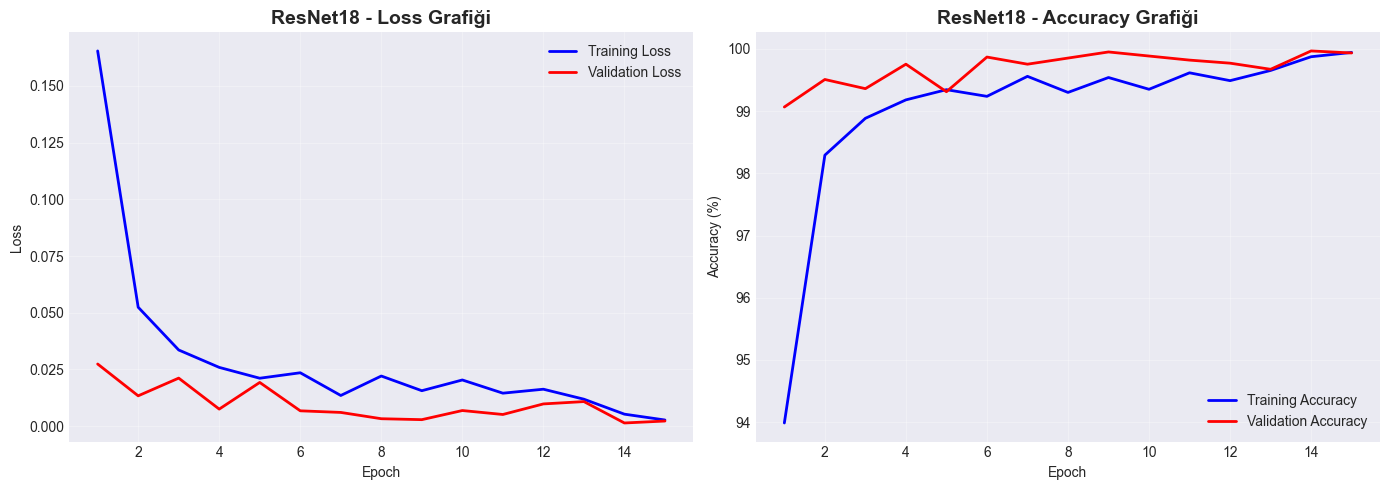

✅ ResNet18 grafiği kaydedildi: resnet18_training_history.png


In [34]:
# ResNet18 eğitim grafiği
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, num_epochs_resnet + 1)

# Loss grafiği
ax1.plot(epochs_range, history_resnet['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, history_resnet['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('ResNet18 - Loss Grafiği', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy grafiği
ax2.plot(epochs_range, history_resnet['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, history_resnet['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('ResNet18 - Accuracy Grafiği', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('resnet18_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ResNet18 grafiği kaydedildi: resnet18_training_history.png")


🏆 TÜM MODELLERİN KARŞILAŞTIRMASI


               Model  Test Accuracy
 ResNet18 (15 epoch)         100.00
Basit CNN (20 epoch)          96.97
Basit CNN (10 epoch)          87.88

🏆 Kazanan: ResNet18 (15 epoch)
📊 Test Accuracy: 100.00%


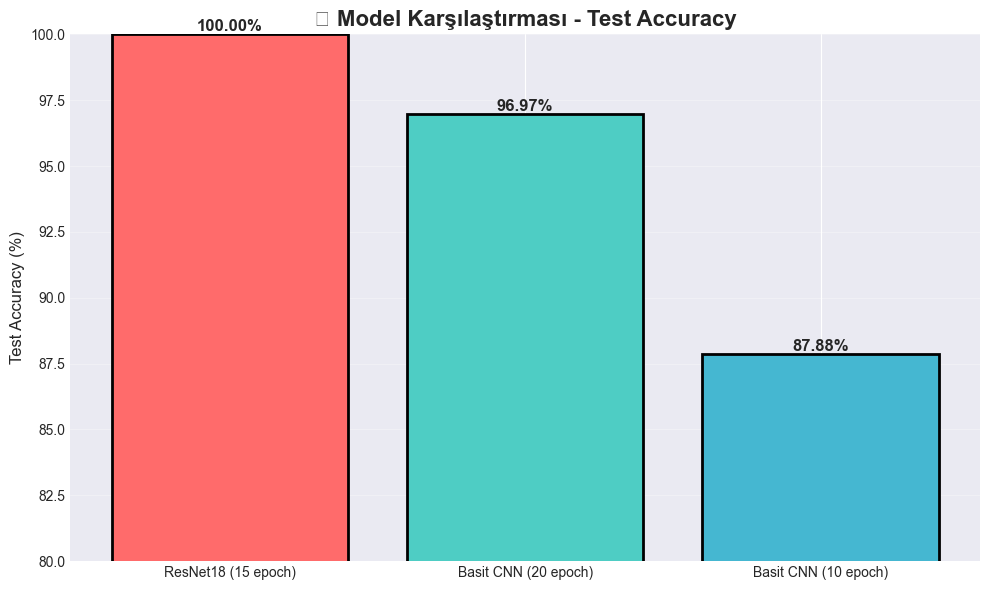


✅ Karşılaştırma grafiği kaydedildi: model_comparison.png


In [35]:
print("\n" + "="*70)
print("🏆 TÜM MODELLERİN KARŞILAŞTIRMASI")
print("="*70)

results = {
    'Model': [
        'Basit CNN (10 epoch)',
        'Basit CNN (20 epoch)',
        'ResNet18 (15 epoch)'
    ],
    'Test Accuracy': [
        87.88,
        96.97,
        test_acc_resnet
    ]
}

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('Test Accuracy', ascending=False)

print("\n")
print(df_results.to_string(index=False))

# En iyi model
best_model = df_results.iloc[0]
print(f"\n🏆 Kazanan: {best_model['Model']}")
print(f"📊 Test Accuracy: {best_model['Test Accuracy']:.2f}%")

# Karşılaştırma grafiği
plt.figure(figsize=(10, 6))
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
bars = plt.bar(df_results['Model'], df_results['Test Accuracy'], color=colors, edgecolor='black', linewidth=2)

# Değerleri barların üstüne yaz
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('🏆 Model Karşılaştırması - Test Accuracy', fontsize=16, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.ylim(80, 100)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Karşılaştırma grafiği kaydedildi: model_comparison.png")
print("="*70)

🔍 CONFUSION MATRIX - TÜM MODELLER


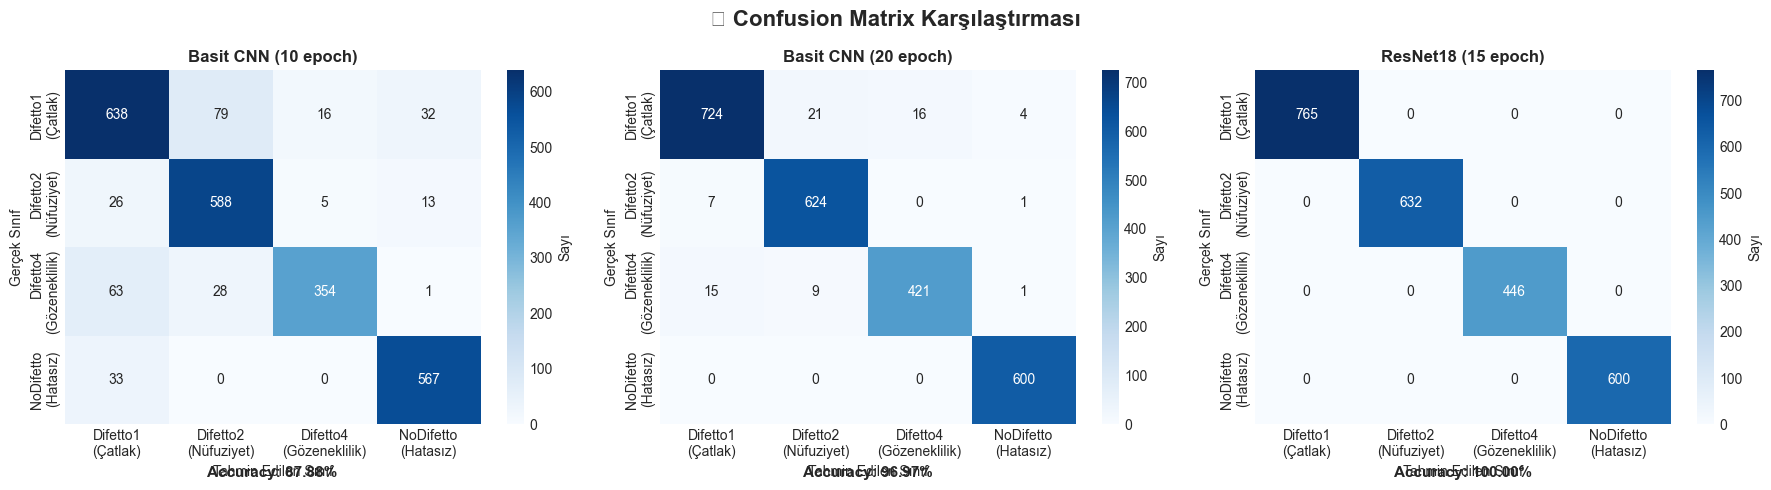

✅ Confusion matrix karşılaştırması kaydedildi: confusion_matrix_comparison.png


In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

print("="*70)
print("🔍 CONFUSION MATRIX - TÜM MODELLER")
print("="*70)

# Sınıf isimleri
class_labels = ['Difetto1\n(Çatlak)', 'Difetto2\n(Nüfuziyet)', 'Difetto4\n(Gözeneklilik)', 'NoDifetto\n(Hatasız)']

# 3 model
models_dict = {
    'Basit CNN (10 epoch)': ('best_model.pth', model),
    'Basit CNN (20 epoch)': ('simple_cnn_20epoch_best.pth', model),
    'ResNet18 (15 epoch)': ('resnet18_best.pth', model_resnet)
}

# Her model için confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('🎯 Confusion Matrix Karşılaştırması', fontsize=16, fontweight='bold')

for idx, (model_name, (model_path, model_obj)) in enumerate(models_dict.items()):
    # Modeli yükle
    model_obj.load_state_dict(torch.load(model_path))
    model_obj.eval()
    
    # Test seti üzerinde tahmin yap
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model_obj(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Confusion matrix hesapla
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize et (yüzdelik)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Görselleştir
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Sayı'}, ax=ax)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Gerçek Sınıf', fontsize=10)
    ax.set_xlabel('Tahmin Edilen Sınıf', fontsize=10)
    
    # Accuracy hesapla
    accuracy = np.trace(cm) / np.sum(cm) * 100
    ax.text(0.5, -0.15, f'Accuracy: {accuracy:.2f}%', 
            transform=ax.transAxes, ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix karşılaştırması kaydedildi: confusion_matrix_comparison.png")

In [37]:
print("\n" + "="*70)
print("📋 DETAYLI SINIFLANDIRMA RAPORLARI")
print("="*70)

class_names_list = ['Difetto1 (Çatlak)', 'Difetto2 (Nüfuziyet)', 'Difetto4 (Gözeneklilik)', 'NoDifetto (Hatasız)']

for model_name, (model_path, model_obj) in models_dict.items():
    print(f"\n{'='*70}")
    print(f"📊 {model_name}")
    print(f"{'='*70}")
    
    # Modeli yükle
    model_obj.load_state_dict(torch.load(model_path))
    model_obj.eval()
    
    # Test seti üzerinde tahmin yap
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model_obj(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Sınıflandırma raporu
    print(classification_report(all_labels, all_preds, target_names=class_names_list, digits=4))

print("\n" + "="*70)


📋 DETAYLI SINIFLANDIRMA RAPORLARI

📊 Basit CNN (10 epoch)
                         precision    recall  f1-score   support

      Difetto1 (Çatlak)     0.8395    0.8340    0.8367       765
   Difetto2 (Nüfuziyet)     0.8460    0.9304    0.8862       632
Difetto4 (Gözeneklilik)     0.9440    0.7937    0.8624       446
    NoDifetto (Hatasız)     0.9250    0.9450    0.9349       600

               accuracy                         0.8788      2443
              macro avg     0.8886    0.8758    0.8800      2443
           weighted avg     0.8813    0.8788    0.8783      2443


📊 Basit CNN (20 epoch)
                         precision    recall  f1-score   support

      Difetto1 (Çatlak)     0.9705    0.9464    0.9583       765
   Difetto2 (Nüfuziyet)     0.9541    0.9873    0.9705       632
Difetto4 (Gözeneklilik)     0.9634    0.9439    0.9536       446
    NoDifetto (Hatasız)     0.9901    1.0000    0.9950       600

               accuracy                         0.9697      2443
  

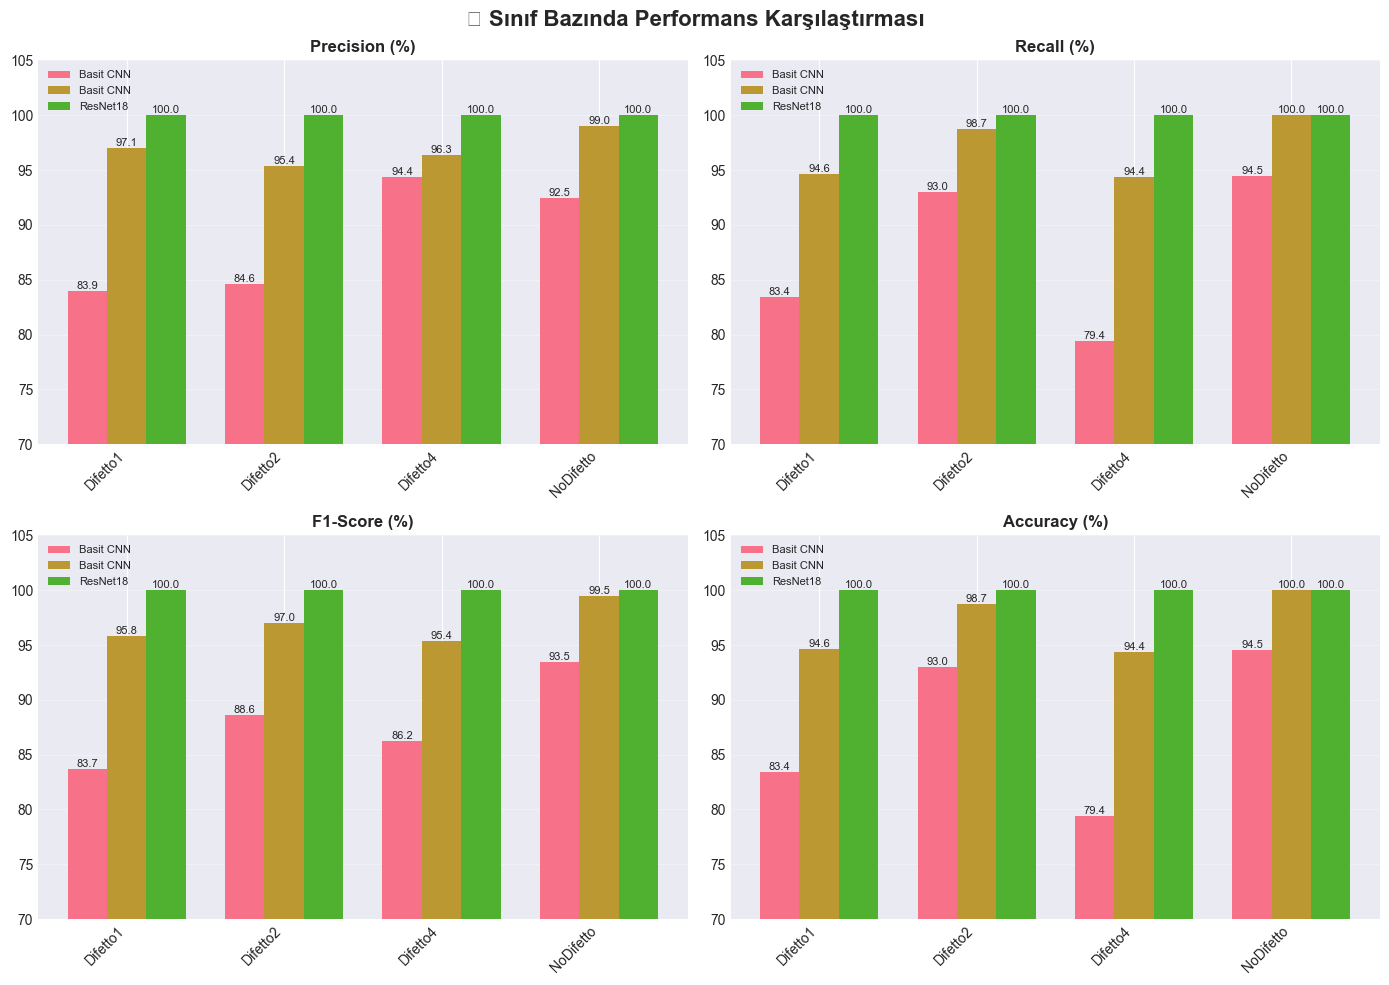

✅ Sınıf bazında performans grafiği kaydedildi: class_performance_comparison.png


In [38]:
# Her sınıf için performans karşılaştırması
from sklearn.metrics import precision_recall_fscore_support

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('📊 Sınıf Bazında Performans Karşılaştırması', fontsize=16, fontweight='bold')

metrics_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
class_names_short = ['Difetto1', 'Difetto2', 'Difetto4', 'NoDifetto']

for metric_idx, metric_name in enumerate(metrics_names):
    ax = axes[metric_idx // 2, metric_idx % 2]
    
    # Her model için metrik
    width = 0.25
    x = np.arange(len(class_names_short))
    
    for model_idx, (model_name, (model_path, model_obj)) in enumerate(models_dict.items()):
        # Modeli yükle ve tahmin yap
        model_obj.load_state_dict(torch.load(model_path))
        model_obj.eval()
        
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = model_obj(images)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        # Metrikleri hesapla
        if metric_name == 'Accuracy':
            # Her sınıf için accuracy
            cm = confusion_matrix(all_labels, all_preds)
            class_accuracies = cm.diagonal() / cm.sum(axis=1) * 100
            values = class_accuracies
        else:
            precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
            if metric_name == 'Precision':
                values = precision * 100
            elif metric_name == 'Recall':
                values = recall * 100
            else:  # F1-Score
                values = f1 * 100
        
        # Çiz
        offset = width * (model_idx - 1)
        bars = ax.bar(x + offset, values, width, label=model_name.split('(')[0].strip())
        
        # Değerleri yaz
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', fontsize=8)
    
    ax.set_title(f'{metric_name} (%)', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names_short, rotation=45, ha='right')
    ax.set_ylim(70, 105)
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('class_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Sınıf bazında performans grafiği kaydedildi: class_performance_comparison.png")